# MultiClass Text Classification with BERT

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [1]:
#from google.colab import drive
#drive.mount("/content/gdrive")

In [2]:
#!pip install -qq transformers
#!pip install torch===1.7.1 torchvision===0.8.2 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html


In [3]:
#@title Setup & Config


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm import tqdm




In [4]:
import transformers
from transformers import BertModel, BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#clearing cuda cache
torch.cuda.empty_cache()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #gpu not good enough
#device = torch.device("cpu") #change runtime type to GPU to be fast

device

device(type='cuda', index=0)

## Data Exploration

We'll load the reviews dataset:

In [6]:
#df4.to_excel('manualtopiclabels_absa.xlsx')

In [7]:
df = pd.read_excel('08052019_coded_cases_training_data.xlsx')

In [8]:
df.drop_duplicates().reset_index()
df = df.dropna(subset=['Mis_Dis text'])

In [9]:
d = {'Conspiracy Theory':'ID', 'Rumour':'ID', 'Smear':'ID', 'other':'non ID'}
df['ID'] = df.Mis_Dis.replace(d)

In [10]:
df['rating'] = df.ID.factorize()[0]

In [11]:
df

,case,link,Mis_Dis,Mis_Dis text,Social_Impact,Social_Impact text,observed behaviours,observed behaviours text,note,ID,rating
0,10,https://www.radionz.co.nz/international/pacifi...,Smear,Police said a group linked to the Free Papua M...,NaN,NaN,NaN,NaN,NaN,ID,0
1,10,https://www.radionz.co.nz/international/pacifi...,Smear,"A resident from one of the villages, Banti, sa...",NaN,NaN,NaN,NaN,NaN,ID,0
2,10,http://www.humanrightspapua.org/news/23-2017/2...,Smear,The Indonesian military general Gatot Nurmanty...,Erode trust in authorities,"Laurensius Kadepa, a member of the Papuan Prov...",NaN,NaN,Aggravation of the situation,ID,0
3,10,https://www.abc.net.au/news/2017-11-10/papua-s...,Smear,"Hendrik Wanmang, who described himself as a co...",NaN,NaN,NaN,NaN,NaN,ID,0
4,3,https://news.mb.com.ph/2018/08/03/pnp-warns-pu...,Rumour,"Following the series of bombing incidents, a c...",Inciting fear and panic,He urged the public to remain calm but vigilan...,NaN,NaN,NaN,ID,0
...,...,...,...,...,...,...,...,...,...,...,...
199,NaN,NaN,other,"Mohd Firdaus Kamal Intdzam, who worked as a cl...",NaN,NaN,NaN,NaN,NaN,non ID,1
200,NaN,NaN,other,"The Abu Sayyaf Group (ASG), based in the Phili...",NaN,NaN,NaN,NaN,NaN,non ID,1
201,NaN,NaN,other,Understanding money laundering and terrorist f...,NaN,NaN,NaN,NaN,NaN,non ID,1
202,NaN,NaN,other,Malaysia is not isolated from the threats pose...,NaN,NaN,NaN,NaN,NaN,non ID,1


In [12]:
df.rating.value_counts()

1    97
0    97
Name: rating, dtype: int64

In [13]:
df['sentence'] = df['Mis_Dis text'].apply(lambda x: x.strip())

In [14]:
#class_names = ['negative', 'positive']
class_names = [i for i in df.ID.value_counts().sort_index().index.tolist()]

In [15]:
class_names

['ID', 'non ID']

In [16]:
len(class_names)

2

In [17]:
df

,case,link,Mis_Dis,Mis_Dis text,Social_Impact,Social_Impact text,observed behaviours,observed behaviours text,note,ID,rating,sentence
0,10,https://www.radionz.co.nz/international/pacifi...,Smear,Police said a group linked to the Free Papua M...,NaN,NaN,NaN,NaN,NaN,ID,0,Police said a group linked to the Free Papua M...
1,10,https://www.radionz.co.nz/international/pacifi...,Smear,"A resident from one of the villages, Banti, sa...",NaN,NaN,NaN,NaN,NaN,ID,0,"A resident from one of the villages, Banti, sa..."
2,10,http://www.humanrightspapua.org/news/23-2017/2...,Smear,The Indonesian military general Gatot Nurmanty...,Erode trust in authorities,"Laurensius Kadepa, a member of the Papuan Prov...",NaN,NaN,Aggravation of the situation,ID,0,The Indonesian military general Gatot Nurmanty...
3,10,https://www.abc.net.au/news/2017-11-10/papua-s...,Smear,"Hendrik Wanmang, who described himself as a co...",NaN,NaN,NaN,NaN,NaN,ID,0,"Hendrik Wanmang, who described himself as a co..."
4,3,https://news.mb.com.ph/2018/08/03/pnp-warns-pu...,Rumour,"Following the series of bombing incidents, a c...",Inciting fear and panic,He urged the public to remain calm but vigilan...,NaN,NaN,NaN,ID,0,"Following the series of bombing incidents, a c..."
...,...,...,...,...,...,...,...,...,...,...,...,...
199,NaN,NaN,other,"Mohd Firdaus Kamal Intdzam, who worked as a cl...",NaN,NaN,NaN,NaN,NaN,non ID,1,"Mohd Firdaus Kamal Intdzam, who worked as a cl..."
200,NaN,NaN,other,"The Abu Sayyaf Group (ASG), based in the Phili...",NaN,NaN,NaN,NaN,NaN,non ID,1,"The Abu Sayyaf Group (ASG), based in the Phili..."
201,NaN,NaN,other,Understanding money laundering and terrorist f...,NaN,NaN,NaN,NaN,NaN,non ID,1,Understanding money laundering and terrorist f...
202,NaN,NaN,other,Malaysia is not isolated from the threats pose...,NaN,NaN,NaN,NaN,NaN,non ID,1,Malaysia is not isolated from the threats pose...


In [18]:
pd.set_option('display.max_rows', 100)

df.Mis_Dis.value_counts().to_frame()


,Mis_Dis
other,97
Rumour,47
Smear,29
Conspiracy Theory,21


## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [19]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [20]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [21]:
token_lens = []

for txt in df.sentence:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

and plot the distribution:

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


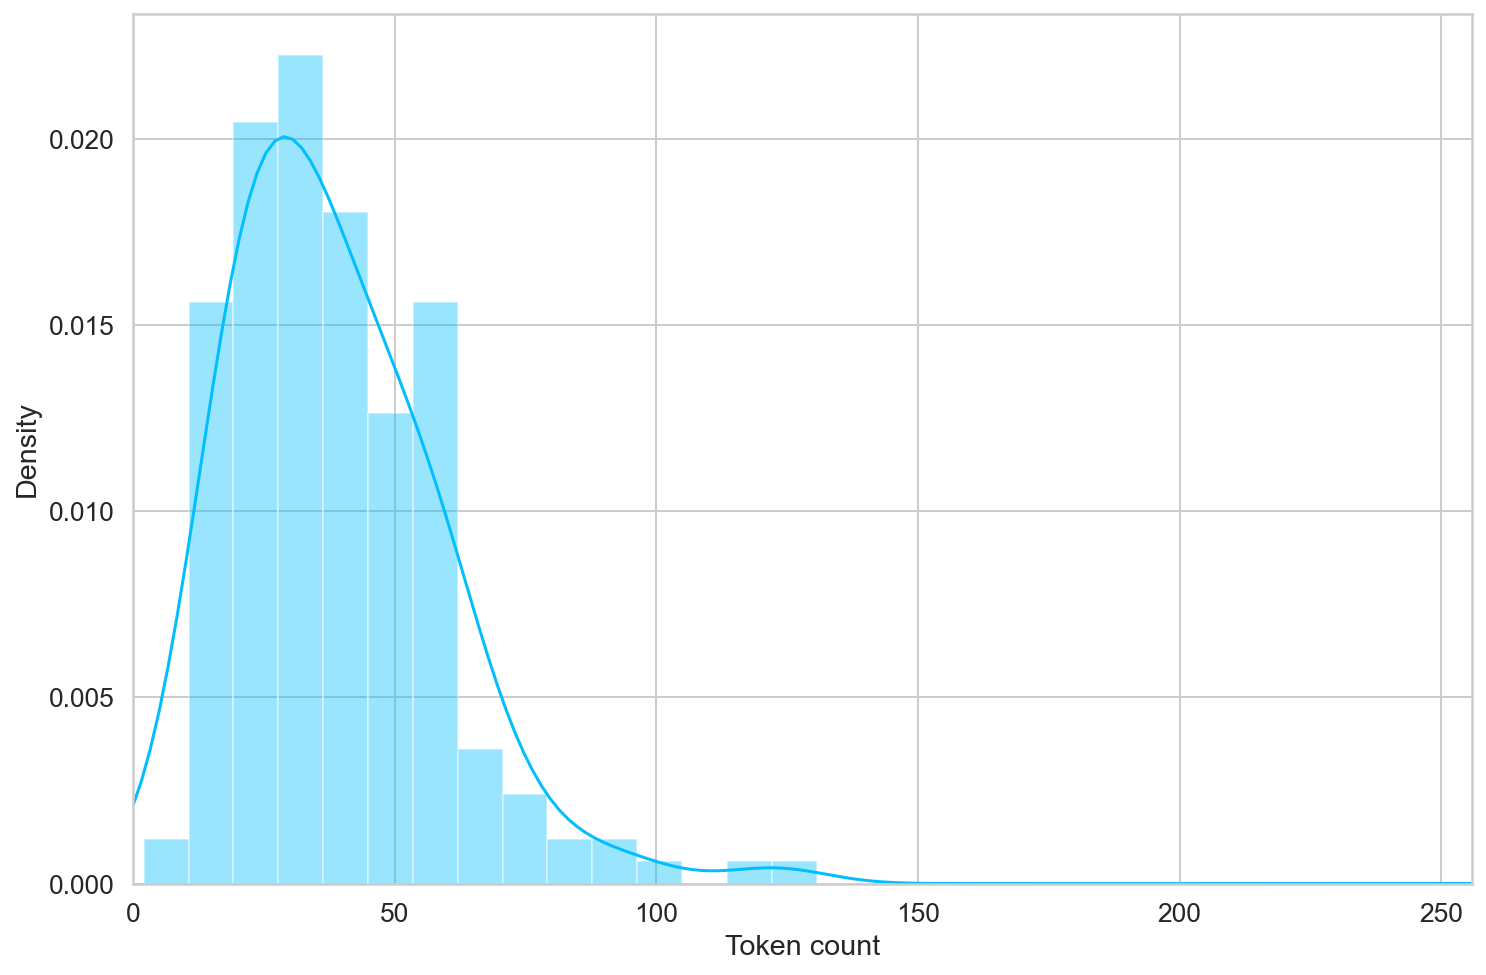

In [22]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 70 tokens, but we'll be on the safe side and choose a maximum length of 80.

In [23]:
print(max(token_lens))
MAX_LEN = 100

285


We have all building blocks required to create a PyTorch dataset. Let's do it:

In [24]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    '''
    if target == 'negative':
       target = 0
    else:
       target = 1
    '''

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #pad_to_max_length=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [25]:
#df_train = df[df.split=="train"]
#df_val = df[df.split=="val"]
#df_test = df[df.split=="test"]

df_train, df_test = train_test_split(df, stratify=df.rating, test_size=0.2, random_state=RANDOM_SEED)
#df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_val = df_test
df_train.shape, df_val.shape, df_test.shape


((155, 12), (39, 12), (39, 12))

In [26]:
#df_train.shape, df_val.shape, df_test.shape

In [27]:
len(df_test.rating.value_counts())

2

We also need to create a couple of data loaders. Here's a helper function to do it:
- Truncation: Truncate to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model if that argument is not provided. 

In [28]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.sentence.to_numpy(),
    targets=df.rating.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    #num_workers=4 #  process hangs with num_workers=4
    num_workers=0,  #  num_workers: how many subprocesses to use for data loading. 0 means that the data will be 
                   #  loaded in the main process. (default: 0)
    shuffle=True   # , drop_last=True
  )

# check

In [29]:
BATCH_SIZE = 5

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [30]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [31]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([5, 100])
torch.Size([5, 100])
torch.Size([5])


In [32]:
tokenizer.convert_ids_to_tokens(data['input_ids'][0])


['[CLS]',
 'she',
 'alleged',
 'military',
 'and',
 'police',
 'personnel',
 'placed',
 'her',
 'under',
 'surveillance',
 'and',
 'ha',
 '##rassed',
 'her',
 'on',
 'several',
 'occasions',
 'in',
 'March',
 'last',
 'year',
 'after',
 'she',
 'handled',
 'the',
 'cases',
 'of',
 'several',
 'persons',
 'accused',
 'of',
 'being',
 'New',
 'People',
 '’',
 's',
 'Army',
 'members',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [33]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [34]:
#Testing

input_ids = data['input_ids']
attention_mask = data['attention_mask']
outputs = bert_model(input_ids=input_ids, 
                     attention_mask=attention_mask)
print(outputs[0].shape,outputs[1].shape)

torch.Size([5, 100, 768]) torch.Size([5, 768])


## Multiclass Classification with BERT and Hugging Face

In [35]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    #self.bert = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.2)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids,
                                 attention_mask=attention_mask,
                                 )
    _ = outputs[0]
    pooled_output = outputs[1]
    output = self.drop(pooled_output)




    return self.out(output)

Let's have a look at an example batch from our training data loader:

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

We can use all of this knowledge to create a classifier that uses the BERT model:

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [36]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [37]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([5, 100])
torch.Size([5, 100])
torch.Size([5])


In [38]:
df.rating.value_counts().sort_index()

0    97
1    97
Name: rating, dtype: int64

In [39]:
#class_names = [i for i in df.rating.value_counts().sort_index().index.tolist()]
print(class_names)

model = SentimentClassifier(len(class_names))
model = model.to(device)

['ID', 'non ID']


In [40]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data["targets"].to(device)
F.softmax(model(input_ids=input_ids, attention_mask=attention_mask), dim=1)

tensor([[0.2935, 0.7065],
        [0.2159, 0.7841],
        [0.2992, 0.7008],
        [0.3995, 0.6005],
        [0.2456, 0.7544]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [41]:
outputs = model(input_ids=input_ids, attention_mask=attention_mask)
outputs.shape

torch.Size([5, 2])

In [42]:
print(targets) 

tensor([0, 1, 1, 0, 0], device='cuda:0')


In [43]:
_, preds = torch.max(outputs, dim=1)
print(preds)


tensor([1, 1, 1, 1, 1], device='cuda:0')


In [44]:
preds == targets

tensor([False,  True,  True, False, False], device='cuda:0')

We'll move the example batch of our training data to the GPU:

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [45]:
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [46]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    #preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)


    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [47]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in tqdm(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      #preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

        
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [49]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Epoch 1/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 12.01it/s]

Train loss 0.5528104014454349 accuracy 0.7032258064516129


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.06it/s]


Val   loss 0.2963445205241442 accuracy 0.8974358974358974



  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Epoch 2/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 12.15it/s]

Train loss 0.11054116951662206 accuracy 0.967741935483871


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.40it/s]


Val   loss 0.20315898826811463 accuracy 0.923076923076923



  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Epoch 3/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 12.46it/s]

Train loss 0.02604391416835208 accuracy 0.9935483870967742


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.4252195554727223 accuracy 0.8974358974358974

Epoch 4/20
----------


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Train loss 0.0018909914989865596 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.2900488766899798 accuracy 0.923076923076923

Epoch 5/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 11.86it/s]

Train loss 0.0007868933664154142 accuracy 1.0


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.15it/s]


Val   loss 0.18662424039575853 accuracy 0.9487179487179487



  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Epoch 6/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 12.15it/s]

Train loss 0.0005715555556479 accuracy 1.0


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.04it/s]


Val   loss 0.17939786463830387 accuracy 0.9743589743589743



  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Epoch 7/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 12.01it/s]

Train loss 0.0004641677284868614 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.18311315041137277 accuracy 0.9743589743589743

Epoch 8/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 12.08it/s]

Train loss 0.0004105957130142938 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.18706128989651916 accuracy 0.9743589743589743

Epoch 9/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 12.01it/s]

Train loss 0.0003376367606124991 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.19045916123286588 accuracy 0.9743589743589743

Epoch 10/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 10.13it/s]

Train loss 0.0003067373848264857 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.19300206495790917 accuracy 0.9743589743589743

Epoch 11/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 12.16it/s]

Train loss 0.0002874318015528843 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.19500351358146872 accuracy 0.9743589743589743

Epoch 12/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 12.38it/s]

Train loss 0.00026913013237889015 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.197009712088402 accuracy 0.9743589743589743

Epoch 13/20
----------


 12%|██████████▌                                                                         | 1/8 [00:00<00:00,  9.20it/s]

Train loss 0.0002481422674346475 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.19879780058363394 accuracy 0.9743589743589743

Epoch 14/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 11.39it/s]

Train loss 0.0002339230202544 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.20027168718479516 accuracy 0.9743589743589743

Epoch 15/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 11.80it/s]

Train loss 0.0002281058447307817 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.20140880161488894 accuracy 0.9743589743589743

Epoch 16/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 12.01it/s]

Train loss 0.00021648406559946916 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.20211044321695226 accuracy 0.9743589743589743

Epoch 17/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 12.53it/s]

Train loss 0.00022629066323485945 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.20273075155637343 accuracy 0.9743589743589743

Epoch 18/20
----------


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Train loss 0.00020305043172782228 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.2032962583743938 accuracy 0.9743589743589743

Epoch 19/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 11.94it/s]

Train loss 0.00019961361343326468 accuracy 1.0


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Val   loss 0.20368256300389476 accuracy 0.9743589743589743

Epoch 20/20
----------


 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 11.94it/s]

Train loss 0.00021101007258684764 accuracy 1.0


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.10it/s]

Val   loss 0.2037256834537402 accuracy 0.9743589743589743

Wall time: 4min 2s


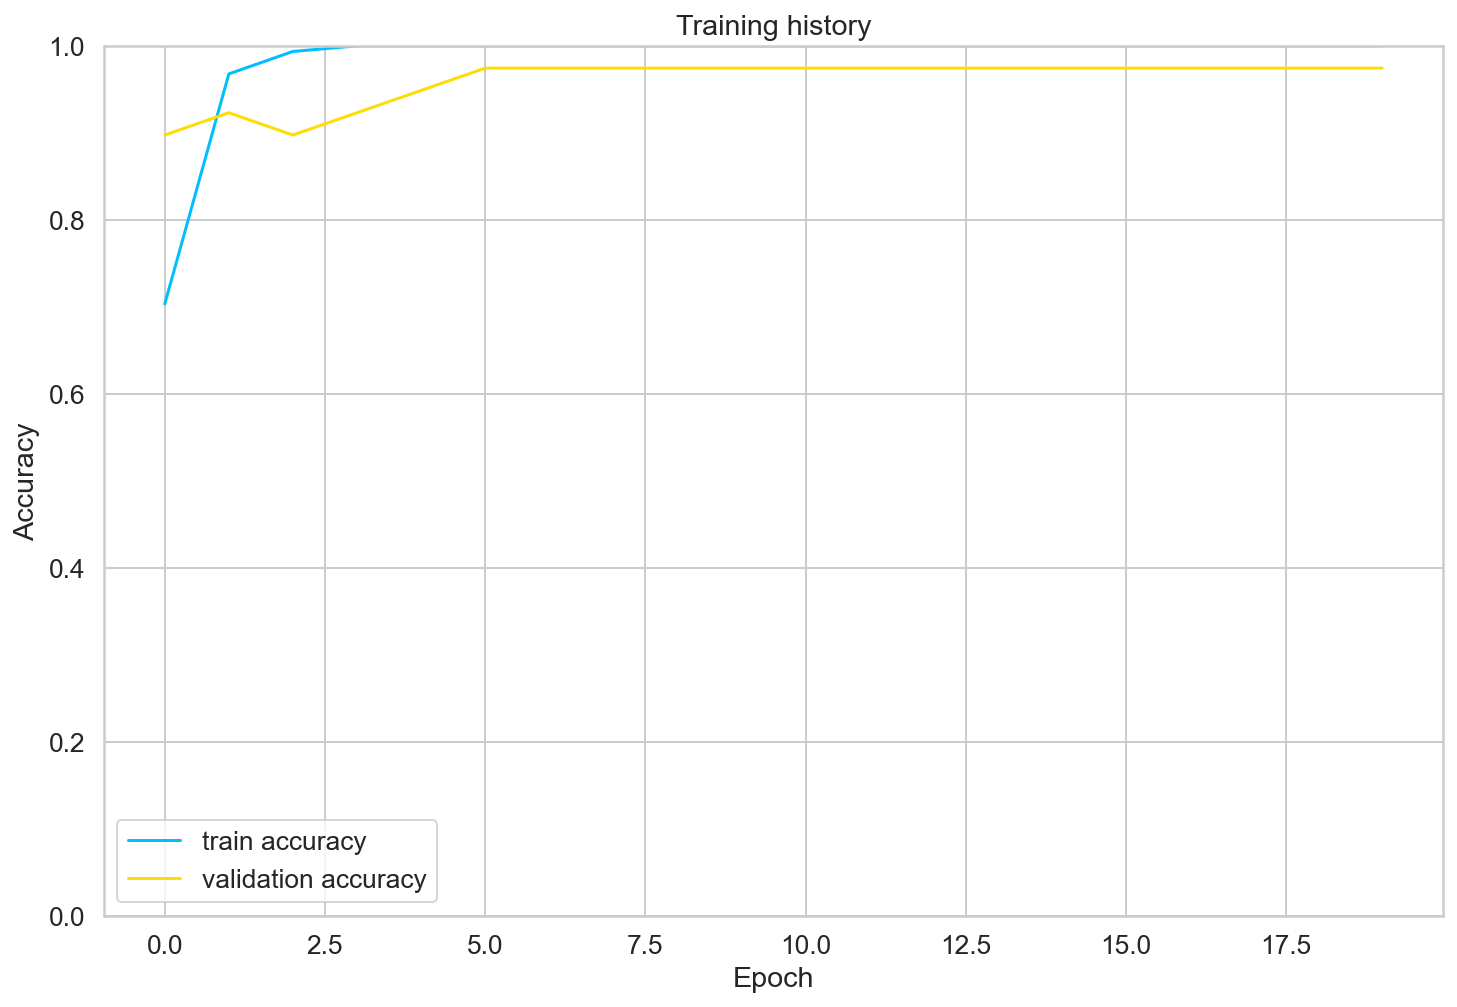

In [50]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

In [48]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [49]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item(), test_loss.item()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.45it/s]


(0.9743589743589743, 0.17938866702388623)

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [50]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [51]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [52]:
for i,j in enumerate(class_names):
    print(i,j)

0 ID
1 non ID


In [53]:
print(classification_report(y_test, y_pred,target_names=class_names))

              precision    recall  f1-score   support

          ID       1.00      0.95      0.97        20
      non ID       0.95      1.00      0.97        19

    accuracy                           0.97        39
   macro avg       0.97      0.97      0.97        39
weighted avg       0.98      0.97      0.97        39



We'll continue with the confusion matrix:

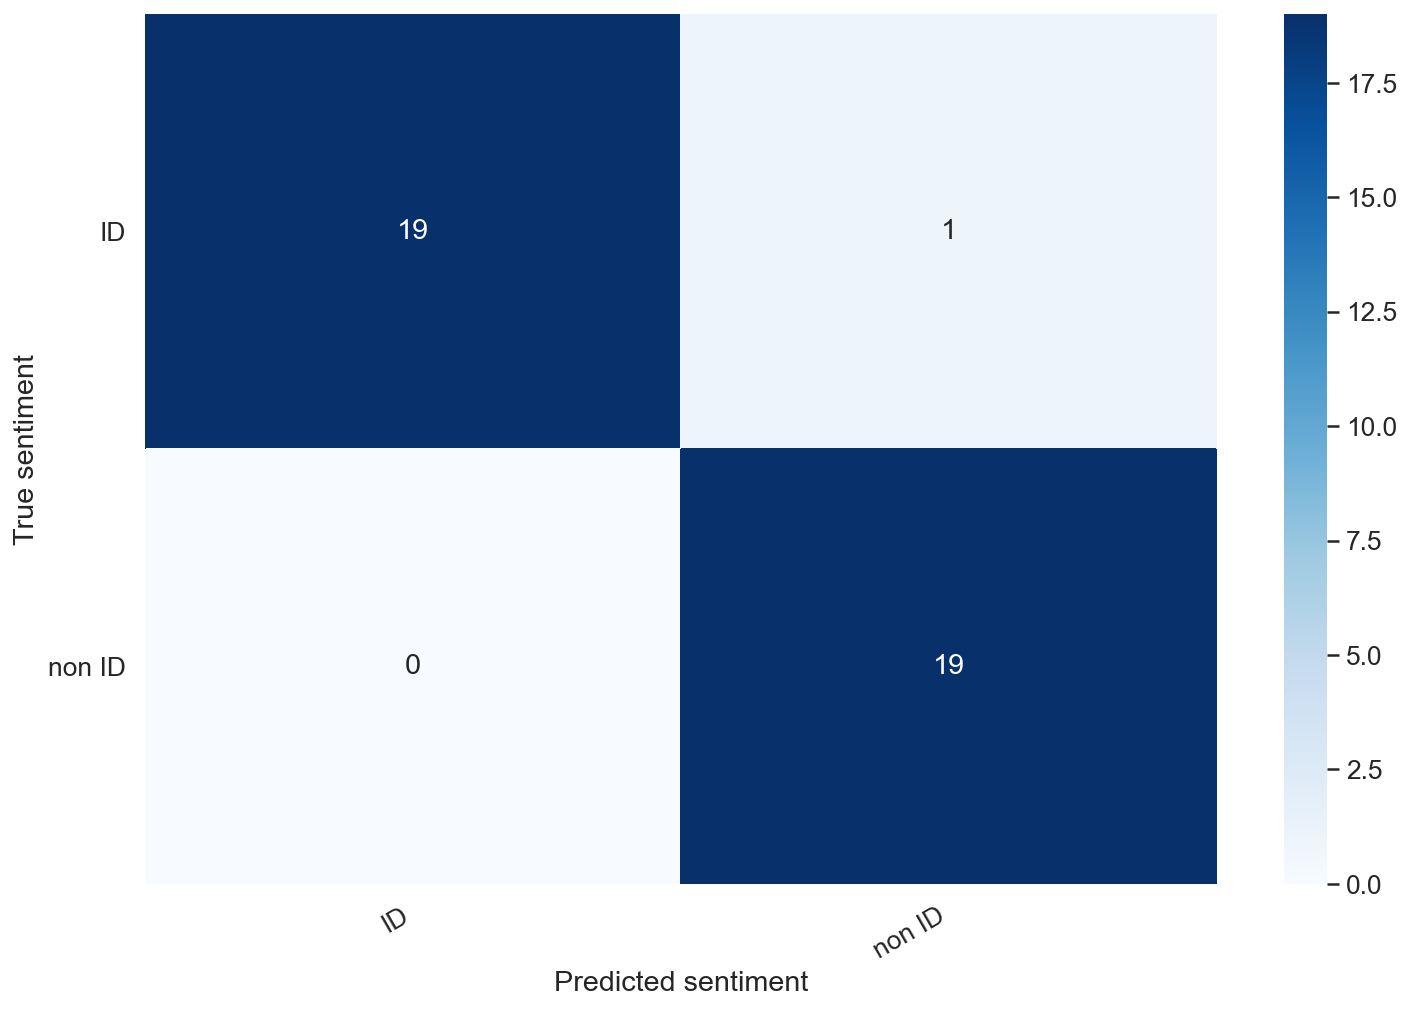

In [54]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [55]:
idx = 3

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [56]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

“Don’t distort it and say the government did it. No government would
be crazy enough to do that, except people who want to be the
government and think of doing it,” junta chairman Prayuth Chan-ocha
told reporters Tuesday.

True sentiment: ID


Now we can look at the confidence of each sentiment of our model:

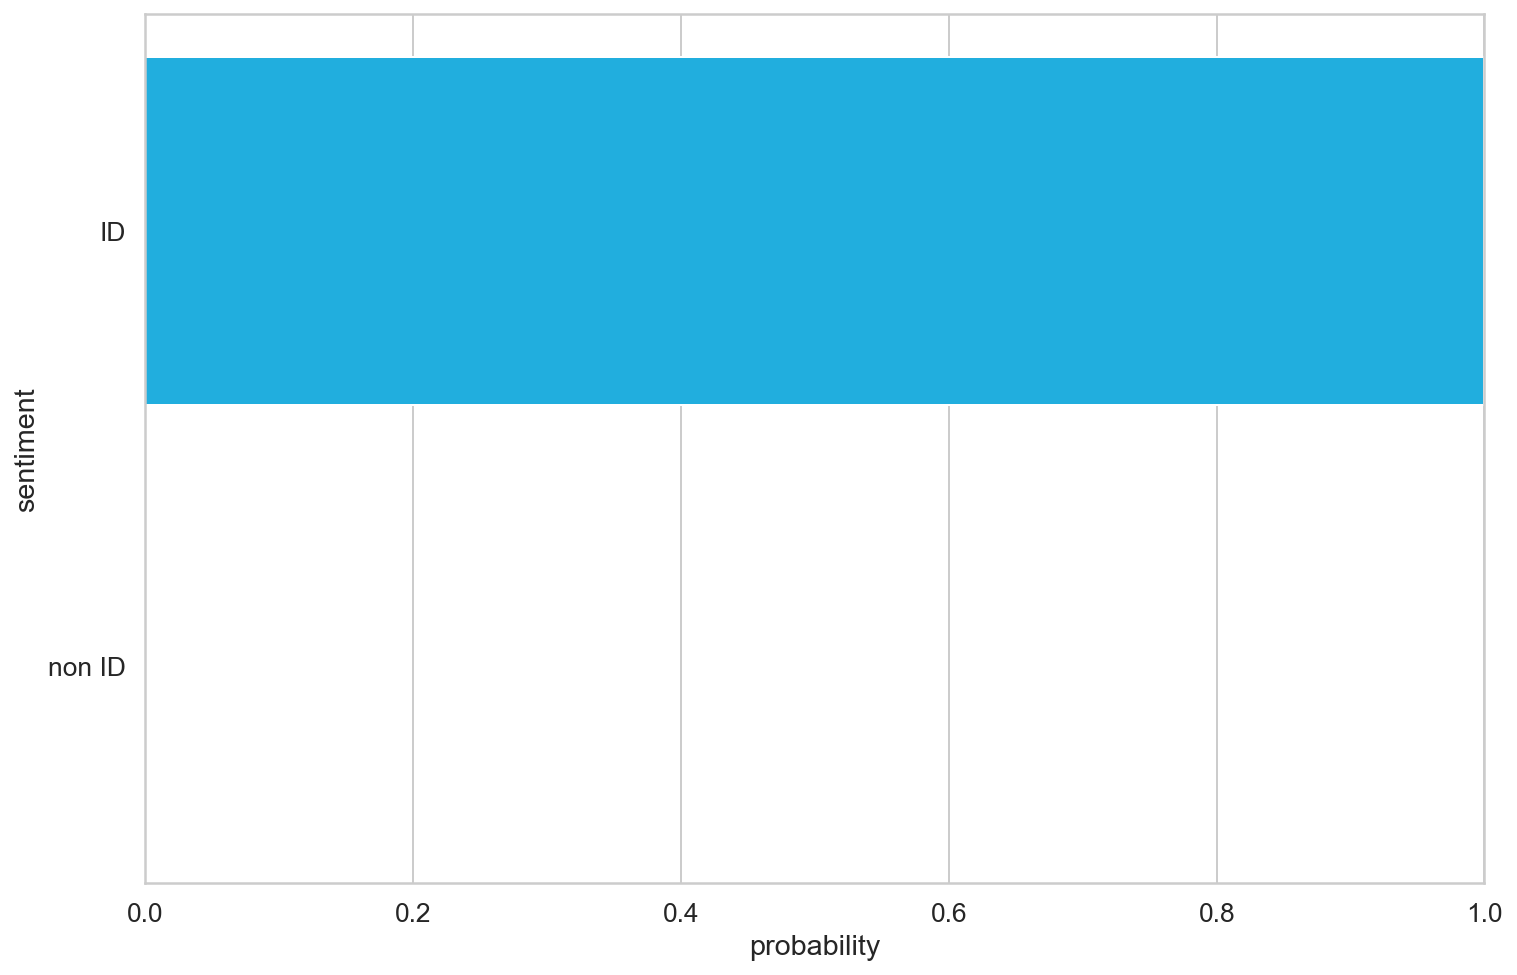

In [57]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the label of the tweets:

In [58]:
from nltk import sent_tokenize
import re
from bs4 import BeautifulSoup

import os


In [59]:
additional_stop_words = ['image omitted','sticker omitted','video omitted','GIF omitted']

def text_cleanup(text):  
    '''
    Text pre-processing
        return a sentence of cleaned words
    '''
    text_clean = str(text)
    #remove html tags
    text_clean = BeautifulSoup(text, "lxml").text

    ## Convert to lowercase
    #text_clean = text_clean.lower()

    #remove stop phrases
    for stop in additional_stop_words:
        text_clean = text_clean.replace(stop, '')
      
    ##Remove non-alphabet
    text_clean = re.sub(r'[^a-zA-Z0-9]|(\w+:\/\/\S+)',' ', text_clean)
  
    ##spliting into tokens
    #text_clean = text_clean.split()

    ##Remove short words (length < 3)
    #text_clean = [w for w in text_clean if len(w)>2]

    ##Lemmatize text ## alternative is to use stemming
    #lemmatizer = WordNetLemmatizer()
    #text_clean = [lemmatizer.lemmatize(w) for w in text_clean]
    
    #ps = PorterStemmer()
    #text_clean = [ps.stem(w) for w in text_clean]
    
    ## Filter out stop words in English 
          
    #stops = set(stopwords.words('english'))
    #text_clean = [w for w in text_clean if w not in stops]
    
    #joining the list into a sentence
    #mySeparator = " "
    #text_clean = mySeparator.join(text_clean)


    return text_clean

text = 'image omitted Why so serioys'
text_cleanup(text)

' Why so serioys'

In [60]:
def label_text(text,class_names,verbose=False):
    topic_sentences = []
    try:        
        review_text = text
    

        encoded_review = tokenizer.encode_plus(
                                                review_text,
                                                max_length=MAX_LEN,
                                                add_special_tokens=True,
                                                return_token_type_ids=False,
                                                #pad_to_max_length=True,
                                                padding='max_length',
                                                return_attention_mask=True,
                                                return_tensors='pt',
                                                truncation=True
                                                )

        input_ids = encoded_review['input_ids'].to(device)
        attention_mask = encoded_review['attention_mask'].to(device)

        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)
        prob_range = F.softmax(output, dim=1).tolist()

        prob = max(prob_range[0])

        #this is a weird multi-class thing that I'm doing, which is to accept probabilities greater than 1/number of classes
        prob_range = [(class_names[i],j) for i,j in enumerate(prob_range[0]) if j>(1/len(class_names))]

        topic_sentences.append({'txt':review_text,
                                'sent_pred':class_names[prediction],
                                'sent_pred_prob':prob,
                                'sent_prob_range':prob_range})


        if verbose==True:
            print(prob)
            print(f'Review text: {review_text}')
            print(f'Sentiment  : {class_names[prediction]}')
            print(f'prob  : {prob}')
            print(f'prob_range: {prob_range}')

        return topic_sentences
    except:
        return topic_sentences

    
print(msg_df['message2'].iloc[4])
label_text(msg_df['message2'].iloc[1],class_names,verbose=True)

NameError: name 'msg_df' is not defined

In [61]:
import glob

path = r'D:\PACK\HTBSC Project\Information Disorder and Operations\Terrorism and Fake News Project\Pipeline_FNT\0.2 Data Collection using GTD\h5files_2015_2018'

all_files = glob.glob(path + "/*.h5")

li = []

for filename in all_files:
    li.append(filename)
li

['D:\\PACK\\HTBSC Project\\Information Disorder and Operations\\Terrorism and Fake News Project\\Pipeline_FNT\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_11345.h5',
 'D:\\PACK\\HTBSC Project\\Information Disorder and Operations\\Terrorism and Fake News Project\\Pipeline_FNT\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_13538.h5',
 'D:\\PACK\\HTBSC Project\\Information Disorder and Operations\\Terrorism and Fake News Project\\Pipeline_FNT\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_13539.h5',
 'D:\\PACK\\HTBSC Project\\Information Disorder and Operations\\Terrorism and Fake News Project\\Pipeline_FNT\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_7553.h5',
 'D:\\PACK\\HTBSC Project\\Information Disorder and Operations\\Terrorism and Fake News Project\\Pipeline_FNT\\0.2 Data Collection using GTD\\h5files_2015_2018\\201501010014_7554.h5',
 'D:\\PACK\\HTBSC Project\\Information Disorder and Operations\\Terrorism and

In [62]:
pd.read_pickle(li[0])

0    https://www.heraldsun.com.au/news/breaking-new...
1                                         201501010014
2    [var exodus = {};\nexodus.campaigns = [{"exodu...
Name: 0, dtype: object

In [63]:
#takes a series and processes the text

from nltk.corpus import stopwords
import re

stop = stopwords.words('english')

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer() 

#this is done so that i can apply lambda function without too much for loops by mapping the stem function to the words
def mapstem(lst):
    return [stemmer.stem(i) for i in lst]

def maplem(lst):
    return [lemmatizer.lemmatize(i) for i in lst]


def txt_preprocess(series):
    #convert to df
    df = series.to_frame().transpose()
    df.columns=['link','gtd_id','txts']
    #melting list
    df = df.txts.apply(pd.Series)\
    .merge(df, right_index = True, left_index = True)\
    .drop(["txts"], axis = 1)\
    .melt(id_vars = ['link','gtd_id'], value_name = "txt") \
    .drop("variable", axis = 1) \
    .drop_duplicates()\
    .dropna()
    #display(df.tail())
    #display(type(df['txt'][0]))
    
    col = 'txt'
    #lower case
    df[col] = df[col].apply(lambda x: " ".join(x.lower() for x in x.split()))
    #remove "\n"
    df = df.replace('\n',' ', regex=True)
    #remove punctuation
    df[col] = df[col].str.replace('[^\w\s]','')
    #remove stopwords
    df[col] = df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    #tokenize words
    df[col] = df[col].apply(word_tokenize)
    #stem words
#     df[col] = df[col].apply(lambda x: maplem(x))
    #stitching
    df[col] = df[col].apply(lambda x: ' '.join(x))
    
    return df

#this method quite computationally expensive cos you are running things at o(n^2)
class NothingToAnalyse(Exception):
    pass


#gives the maximum value of h5
def label_h5(h5):
    series=pd.read_pickle(h5)
    #print(series[2])
    #print(type(series[2]))
    if series[2] == []:
        raise NothingToAnalyse
        print('Nothing to analyse!')
    else:
        frame = txt_preprocess(series).reset_index()
        #print('frame len:' + str(len(frame)))
        #display(frame.drop_duplicates())
    
    _  = []
    for i in range(len(frame)):
        #display(label_text(frame['txt'].iloc[i],class_names,verbose=True))
        _ = _ + label_text(frame['txt'].iloc[i],class_names)
        
    #display(pd.DataFrame(_))
    
    frame = pd.concat([frame,pd.DataFrame(_)],axis=1)
    return (frame[frame.sent_pred == 'ID'])

label_h5(li[0])

,index,link,gtd_id,txt,txt,sent_pred,sent_pred_prob,sent_prob_range
64,85,https://www.heraldsun.com.au/news/breaking-new...,201501010014,world breaking newstwo police guard killed pap...,world breaking newstwo police guard killed pap...,ID,0.991948,"[(ID, 0.9919481873512268)]"
70,99,https://www.heraldsun.com.au/news/breaking-new...,201501010014,two policemen security guard working usowned m...,two policemen security guard working usowned m...,ID,0.987700,"[(ID, 0.9876998662948608)]"
71,100,https://www.heraldsun.com.au/news/breaking-new...,201501010014,two policemen security guard working usowned m...,two policemen security guard working usowned m...,ID,0.987700,"[(ID, 0.9876998662948608)]"


In [61]:
# _ = pd.DataFrame()

_ = pd.read_pickle('filtered_url.h5')

In [62]:
os.path.getsize(li[1319])

1333221326

In [70]:
pd.read_pickle(li[11888])[0]

'http://docshare.tips/list-of-programs-broadcast-by-intercontinental-broadcasting-corporation_5827f10ab6d87f24b08b4a00.html'

In [64]:
os.path.getsize(li[13673])

21679348

In [67]:
li[1319]

'D:\\PACK\\HTBSC Project\\Information Disorder and Operations\\Terrorism and Fake News Project\\Pipeline_FNT\\0.2 Data Collection using GTD\\h5files_2015_2018\\201505190077_6867.h5'

In [65]:
os.path.getsize(li[13674])

43364683

In [64]:
capture_later = []

_ = pd.DataFrame()

for i in range(10000,16251):
    try:
        if os.path.getsize(li[i]) > 10000000: #for files bigger than 10Mb
            capture_later.append(li[i])
            print(f'{i} is too large, skipping')
        else:
            print(i,end='\r')
            _2 = label_h5(li[i])
            _ = pd.concat([_,_2])
            _.to_pickle('filtered_url3.h5')
    except NothingToAnalyse:
        continue

10023 is too large, skipping
10311 is too large, skipping
11888 is too large, skipping
12399 is too large, skipping
12736 is too large, skipping
12919 is too large, skipping
13166 is too large, skipping
13399 is too large, skipping
13564 is too large, skipping
13646 is too large, skipping
13672 is too large, skipping
13673 is too large, skipping
13674 is too large, skipping
13676 is too large, skipping
13678 is too large, skipping
13680 is too large, skipping
13687 is too large, skipping
13688 is too large, skipping
14034 is too large, skipping
14670 is too large, skipping
14712 is too large, skipping
15015 is too large, skipping
15101 is too large, skipping
15118 is too large, skipping
16078 is too large, skipping
16161 is too large, skipping
16192 is too large, skipping
16193 is too large, skipping


IndexError: list index out of range

In [66]:
print(len(li))

16250


In [74]:
for i in capture_later:
    print(pd.read_pickle(i)[0])

https://www.researchgate.net/publication/282357871_Alert_2015_Report_on_conflicts_human_rights_and_peacebuilding
http://docshare.tips/list-of-programs-broadcast-by-intercontinental-broadcasting-corporation_5827f10ab6d87f24b08b4a00.html
https://www.law.georgetown.edu/faculty-staff/faculty-in-the-news/
https://www.lowyinstitute.org/the-interpreter/debate/coronavirus-pandemic
http://whc.unesco.org/en/news/date=2006-04-9&mode=day&index=1&maxrows=1726
https://nowbotmilliondollar.netlify.app/dorsch-friedrich-diccionario-de-psicologia-pdf-printer.html
https://coastguard.gov.ph/component/content/archive/2016/8?Itemid=101
https://www.researchgate.net/publication/40102144_Legitimacy_in_European_nature_conservation_policy_case-studies_in_multilevel_governance
http://www.coastguard.gov.ph/index.php/component/content/archive
https://quod.lib.umich.edu/p/philamer/ACP1475.1904.003?rgn=main;view=fulltext
http://doczz.net/doc/838941/philippinescertified
https://baixardoc.com/documents/indonesian-idf-5d

In [65]:
_ = pd.read_pickle('filtered_url.h5')

_2 = pd.read_pickle('filtered_url3.h5')

_ = pd.concat([_,_2])

In [68]:
len(_.link.value_counts().index.tolist())

4936